# Implementação do algoritmo de Regularização de LASSO

Para este projeto sera usado o Boston dataset onde o objetivo e prever a variável **MEDV** que é o valor médio das casas ocupadas pelos proprietários em US$ 1000.

Existem 14 atributos em cada caso do conjunto de dados. Eles são:

* `CRIM` - taxa de criminalidade per capita por cidade.
* `ZN` - proporção de terrenos residenciais divididos em lotes com mais de 25.000 pés quadrados.
* `INDUS` - proporção de acres comerciais não comerciais por cidade.
* `CHAS` - variável fictícia Charles River (1 se o trecho limita o rio; 0 caso contrário).
* `NOX` - concentração de óxidos nítricos (ações por 10 milhões).
* `RM` - número médio de quartos por moradia.
* `AGE` - proporção de unidades ocupadas pelos proprietários construídas antes de 1940.
* `DIS` - distâncias ponderadas a cinco centros de emprego em Boston.
* `RAD` - índice de acessibilidade às rodovias radiais
* `TAX` - taxa de imposto sobre a propriedade de valor total por US10.000.
* `PRATIO` - proporção aluno-professor por cidade.
* `B-1000` - (Bk - 0,63) ^ 2 onde Bk é a proporção de negros por cidade.
* `LSTAT` - % menor status da população.
* `MEDV` - Valor médio das casas ocupadas pelos proprietários em US 1000.
    
Para mais detalhes consultar o [link](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)

In [5]:
# Manipulação de Dados
import numpy as np
import pandas as pd

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Data Mining
import pingouin as pg
from scipy import stats

# Configurando o estilo de gráfico utilizado
%matplotlib inline
plt.rcParams["figure.figsize"] = 20, 10
plt.style.use('fivethirtyeight')

# Ignorando os avisos
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Carregando o dataset
dataset = 'boston_houses.csv'
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 
           'DIS', 'RAD', 'TAX', 'PTRATIO', 'B-1000', 'LSTAT', 'MEDV']

df = pd.read_csv(dataset, header=None, delimiter=r'\s+', names=columns)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B-1000   506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [7]:
# Checando as primeiras linhas do conjunto de dados
df.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B-1000,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


Algumas variáveis parecem ser assimétricas, principalmente a variável target **'MEDV'**. 

Primeiro vamos olhar unicamente para seu histograma e seu density plot. Depois vamos checar assimétria de todos os atributos por meio do método skew do pandas.

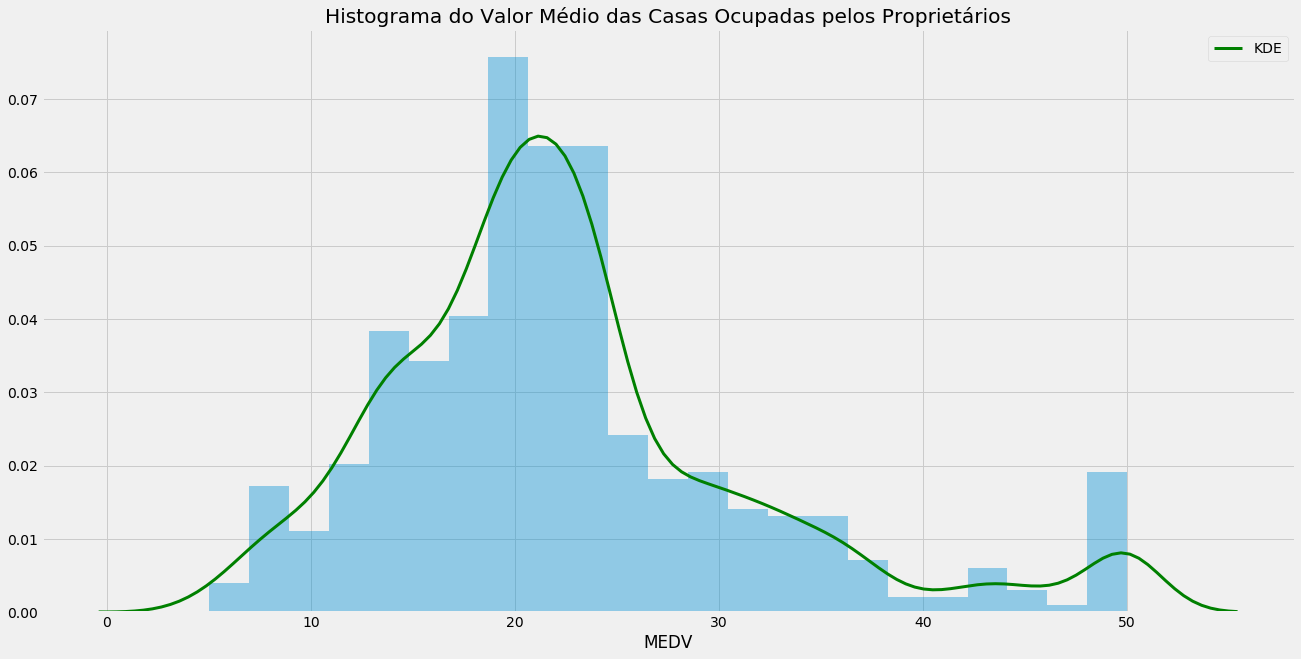

In [9]:
# Histograma e density plot para a variável 'MEDV'
sns.distplot(df['MEDV'], 
             hist=True, 
             kde_kws={'color':'g', 'lw':3, 'label':'KDE'})

# Plota o histograma
plt.title('Histograma do Valor Médio das Casas Ocupadas pelos Proprietários')
plt.show()

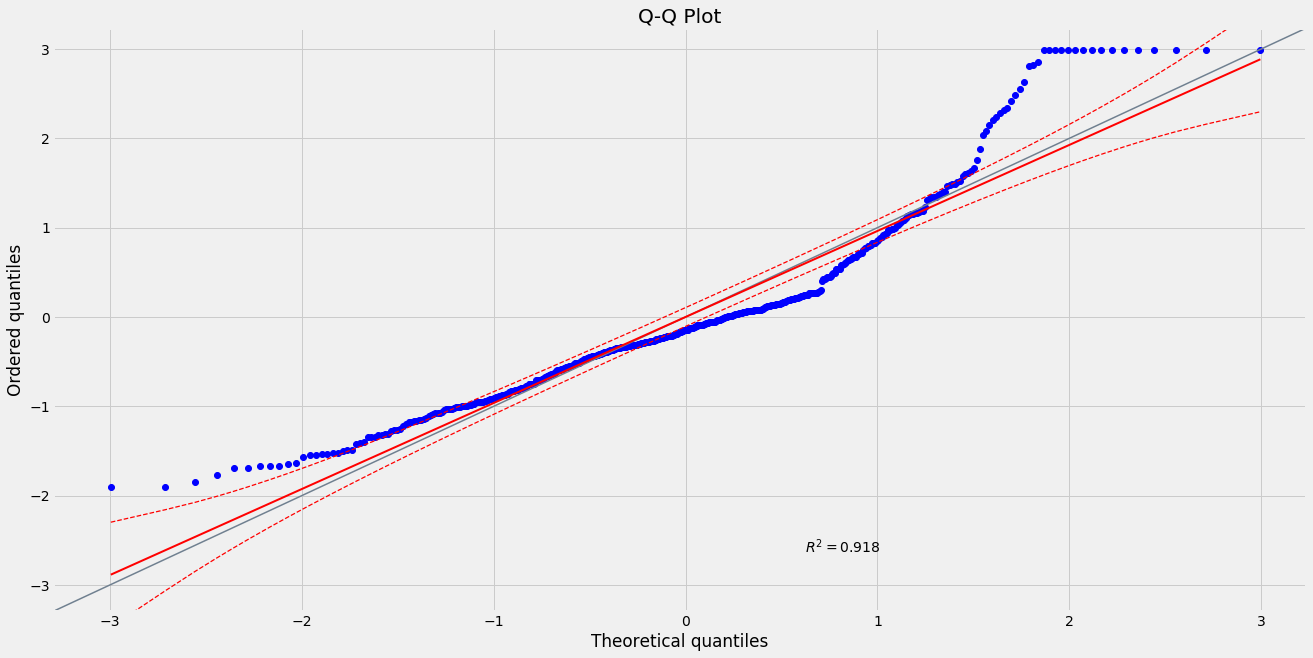

In [11]:
# Cria o gráfico
pg.qqplot(df['MEDV'], 
          dist='norm', 
          figsize=(20, 10))

# Mostra o gráfico
plt.show()

Pelo gráfico primeiro e possivel ver que a variável **'MEDV'** possui uma assimétria a direita, e o gráfico de probabilidade mostra que os dados possuem uma distorção principalmente na sua cauda direita, não se adequando na curva normal, outro sinal de assimetria nos dados.

In [ ]:
# Sumário estístico dos dados
df.describe()

Agora vamos realizar uma análise explorátoria no conjunto de dados para conhecer melhor as variáveis e suas caractériscas.
Vamos começar checando o relacionamento das variáveis através de sua corelação. Para facilitar vamos ver este relacionamento por meio de uma heatmap

In [ ]:
# Correlação das variáveis por meio de um heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(df.corr(method='pearson'), annot=True, linewidths=0.3, square=True)
plt.show()

Agora vamos fazer alguns plots com o pandas para poder conhecer melhor o conjunto de dados.

Começando por um histograma e um gráfico de densidade dos atributos para conhecer melhor suas distribuiçõoes.

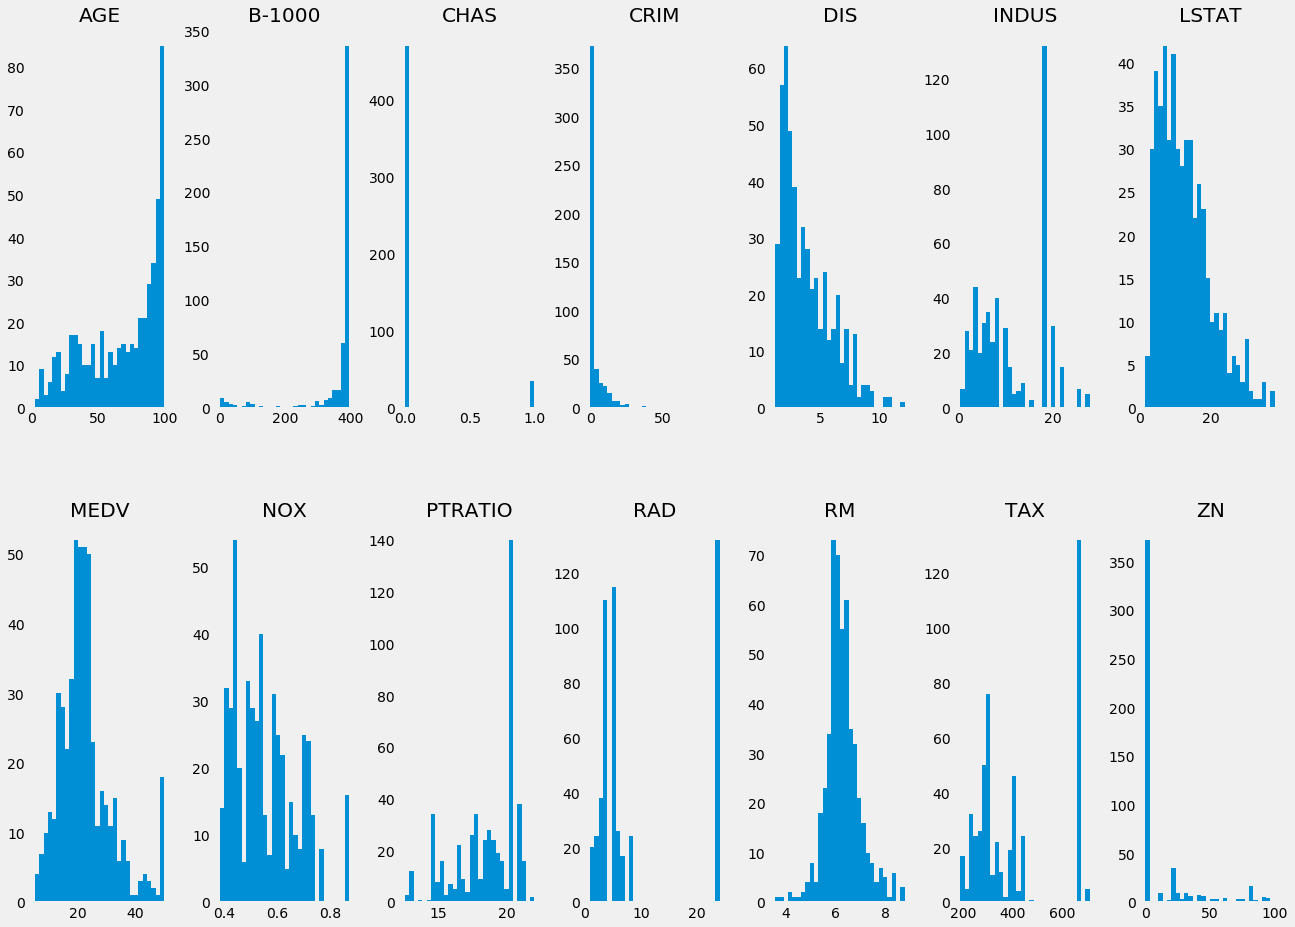

In [12]:
# Histograma dos atributos
df.hist(figsize=(20, 15), layout=(2, 7), bins=30, sharex=False, grid=False)
plt.show()

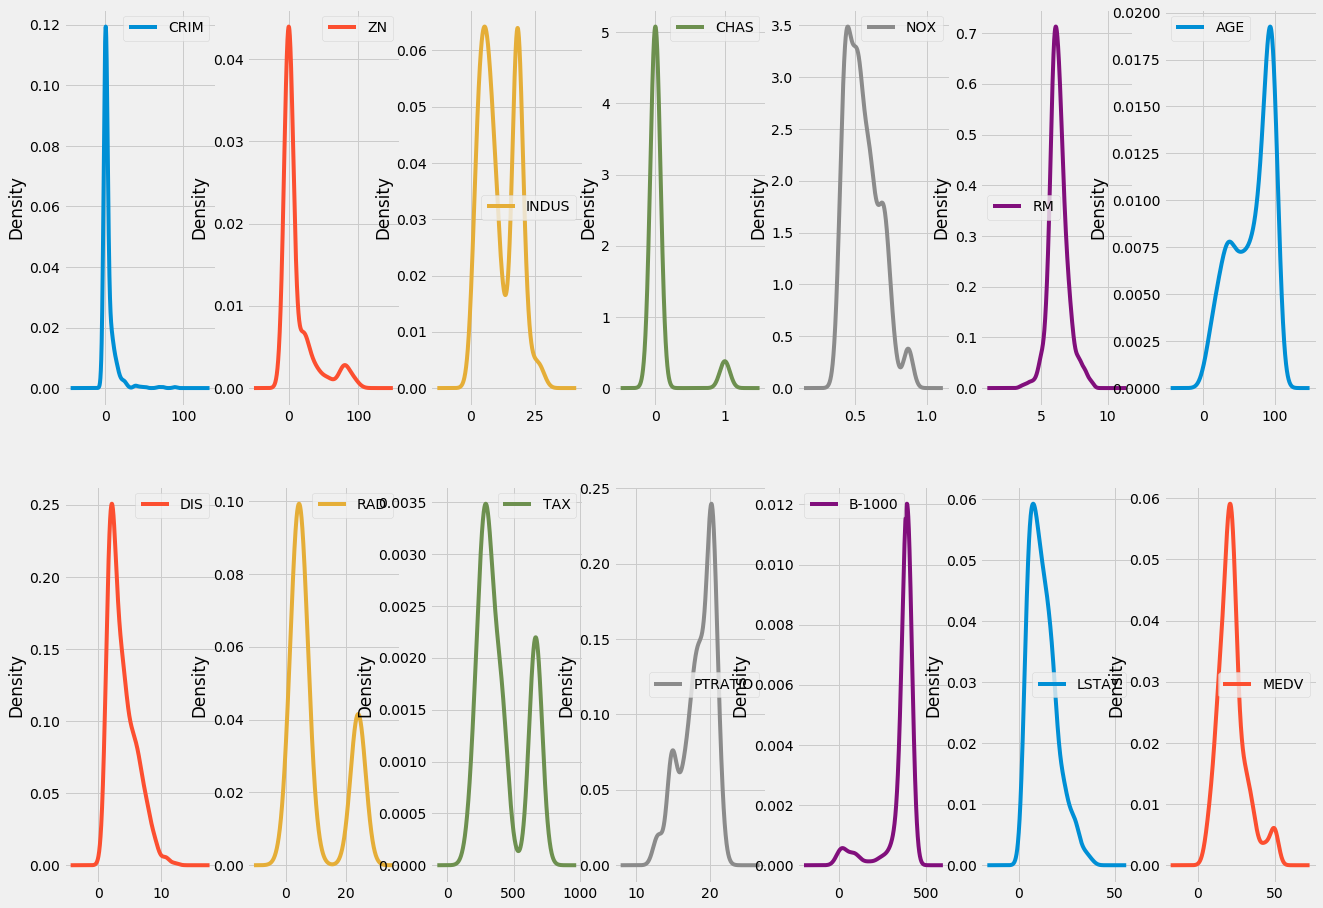

In [13]:
# Gráficos de densidade
df.plot(kind='density', subplots=True, figsize=(20, 15), layout=(2, 7), sharex=False)
plt.show()

Algumas variáveis parecem ser assimétricas, principalmente a variável target **'MEDV'**. 

Primeiro vamos olhar unicamente para seu histograma e seu density plot. Depois vamos checar assimétria de todos os atributos por meio do método skew do pandas.

In [ ]:
# Assimetria das variáveis
df.skew()

Alguns atributos parecem ter assimetria muito elevada e com isso não vão se adequar a curva normal e assim, o modelo aprensentara resultados ruins.

Quando as variáveis possuem uma assimétria muito elevada e não se adequam a curva normal podemos tentar fazer um aproximação de uma curva normal por meio da função *np.log1p*.

In [ ]:
# transformando os atributos
for col in df.columns:
    skew = stats.skew(df[col])
    if skew > 0.75:
        df[col] = np.log1p(df[col])

Em seguida vamos checar se atributos possuem muitos outliers por meio de um boxplot.

In [ ]:
# Boxplot dos atributos
df.plot(kind='box', subplots=True, figsize=(20, 15), layout=(2, 7), sharex=False)
plt.show()

Os atributos, **'CRIM'**, **'RM'**, **'PTRATIO'**, **'B-1000'** e **'MEDV'** possuem outliers vamos remove-los. Mas primeiro vamos normalizar os dados, ou seja, coloca-lós em escala (no caso da normalização um range de 0 á 1), pois fará com que o modelo possua uma melhor performace.

O min-max scaler possue a seguinte formula:

$$\frac{X - X_{min}}{X_{max} - X_{min}}$$

In [ ]:
# Normalizando os dados com Min-Max Scaler
df_norm = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))

# Visualizando o resultado
df_norm.head(10)

In [ ]:
# Removendo outliers
df_norm = df_norm[(np.abs(stats.zscore(df_norm)) < 3).all(axis=1)]

# Checando o resultado
df_norm.info()

Agora vamos checar como ficou o atributo **'MEDV'** depois de todas as transformações

In [ ]:
# Histograma e density plot para a variável 'MEDV'
plt.figure(figsize=(12, 8))
sns.distplot(df_norm['MEDV'], hist=True, 
             kde_kws={"color":"g", "lw":3, 'label':'KDE'})
plt.show()

In [ ]:
# Probability Plot para a variável 'MEDV'
plt.figure(figsize=(12, 8))
stats.probplot(df_norm['MEDV'], dist='norm', plot=plt)
plt.show()

Podemos ver que a distruibuição da variável **'MEDV'** parece mais próxima da curva normal e possui menos assimetria.

Tudo pronto agora vamos dividir o conjunto de dados em treino e teste para que possamos criar o algoritmo.

In [ ]:
# Importando a função train_test_split do módulo scikit learn
from sklearn.model_selection import train_test_split

# Obtendo os valores do dataset
df = df_norm.values

# Dividindo o conjunto de dados em treino e teste
X = df[:, 0:12]
Y = df[:, 13]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## LASSO Regression

Least Absolute Shrinkage and Selection Operator Regression - LASSO é uma versão regularizada da Regressão Linear, ela adiciona um termo de regularização à função de custo mas utiliza norma $\ell_1$

A Regressão de LASSO elimina completamente os pesos dos coeficientes menos importantes. De outro modo a Regressão de LASSO executa automaticamente a seleção de características e exibe um modelo esparso, ou seja, com poucos pesos e caracterísicas diferentes de zero.

A função de custo de LASSO não é diferencial em $\theta_i = 0$ (para todo $i = 1, 2, \dots, n)$, mas o Gradiente Descendente ainda funciona bem se utilizarmos o vetor subgradiente $g$ quando qualquer $\theta_i$ for igual a 0.

Função custo da Regressão de LASSO

$$J(\theta) = \frac{1}{2 * n} \sum_{i=1}^{n} (\theta - \hat{\theta}) + \lambda {\sum}_{i=1}^n|{\theta}_i|$$

Vetor subgradiente da Regressão de LASSO

$$g(\theta, J) = 
{\nabla}_\theta MSE(\theta) + 
\alpha 
\begin{pmatrix} 
sinal(\theta_1) \\
sinal(\theta_2) \\ 
\vdots \\ 
sinal(\theta_n)
\end{pmatrix}$$

$$\text{ onde } sinal(\theta_i) = 
\begin{cases}
-1 & \quad \text{if } \theta_i < 0 \\
0 & \quad \text{if } \theta_i = 0 \\
+1 & \quad \text{if } \theta_i > 0
\end{cases}$$

In [ ]:
# Criando a classe
class LASSO(object):
    
    # Inicializando os parâmetros
    def __init__(self, l1_regularization, learning_rate, n_iterations):
        self.l1_regularization = l1_regularization
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
    
    # Definindo a função treino
    def fit(self, X, y):
        m, n = X_train.shape
        self.weights = np.random.randn(n) / np.sqrt(n)
        self.cost_function = []
        intercept = np.sum(y - np.dot(X, self.weights)) / m
        
        for i in range(self.n_iterations):
            
            yi = np.dot(X, self.weights)
            errors = y - yi
            mse = np.sum(0.5 * (errors**2)) + self.l1_regularization * np.sum(np.abs(self.weights))
            self.cost_function.append(mse)
            gradient = self.weights - (self.learning_rate * (X.T.dot(errors) + self.l1_regularization * np.sign(self.weights)))
            self.weights -= self.learning_rate * gradient
    
    # Definindo a função teste 
    def predict(self, X):
        return (np.dot(X, self.weights))

Agora vamos treinar e testar o modelo para observar se esta correto

In [ ]:
# Criando o modelo e definindo os parâmetros
model = LASSO(l1_regularization=0.15, learning_rate=0.01, n_iterations=500)

# Treinando o modelo
model.fit(X_train, y_train)

# Realizando as previsões
predict = model.predict(X_test)

Agora vamos avaliar o modelo por meio de duas metricas muito utilizadas o Erro Quadrático Médio (MSE) e Erro Absoluto Médio (MAE).

O MSE basicamente mede o erro quadrado médio de nossas previsões. Para cada ponto, calcula a diferença quadrada entre as previsões e o valor real da variável alvo e, em seguida, calcula a média desses valores. O MSE e dado pela seguinte formula:

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y - \hat{y})^{2}$$

O MAE (Mean Absolute Error) é a soma da diferença absoluta entre previsões e valores reais. Fornece uma ideia de quão erradas estão nossas previsões. Valor igual a 0 indica que não há erro, sendo a previsão perfeita. O MAE e dado pela seguinte formula

$$MAE =  \frac{1}{n} \sum_{i=1}^{n} |y - \hat{y}|^{2}$$

In [ ]:
# Importando as duas métricas MSE e MAE do scikit learn
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Erro Quadrático Médio para o modelo
mse = mean_squared_error(y_test, predict)
print("Mean squared error: %s " % (mse))

# Erro Absoluto Médio para o modelo
mae = mean_absolute_error(y_test, predict)
print('Mean Absolute Error: %s' % (mae))

Agora apenas para comparação, vamos comparar os resultados modelo criado com modelos já prontos do scikit learn, para checar se os resultados são semelhantes. Primeiro vamos começar pela Regressão de Lasso e depois comparar o resultado com Stochastic Gradient Descent com regularização $\ell_1$.

In [ ]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.05, random_state=42)

model.fit(X_train, y_train)

Lasso_pred = model.predict(X_test)

mse = mean_squared_error(y_test, Lasso_pred)
print ("Mean squared error: %s (given by reg. factor: %s)" % (mse, 0.05))

mae = mean_absolute_error(y_test, predict)
print('Mean Absolute Error: %s' % (mae))

In [ ]:
from sklearn.linear_model import SGDRegressor

model = SGDRegressor(alpha= 0.05, max_iter=500, penalty='l1', random_state=42)

model.fit(X_train, y_train)

SGDR_pred = model.predict(X_test)

mse = mean_squared_error(y_test, SGDR_pred)
print ("Mean squared error: %s (given by reg. factor: %s)" % (mse, 0.05))

mae = mean_absolute_error(y_test, predict)
print('Mean Absolute Error: %s' % (mae))

### Referências

TIBSHIRANI, Robert. Regression shrinkage and selection via the lasso. Journal of the Royal Statistical Society: Series B (Methodological), v. 58, n. 1, p. 267-288, 1996.

GÉRON, Aurélien. Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.", 2017.